In [520]:
import c14
import c14.models.liver

import numpy as np
import pandas as pd
import scipy as sp
import theano
import theano.tensor as T

import seaborn as sns
import matplotlib.pyplot as plt

In [521]:
# %load_ext autoreload

In [522]:
# %autoreload 2
import pymc3 as pm

In [572]:
import scipy
import theano

floatX = theano.config.floatX

class DE(pm.ode.DifferentialEquation):
    def _simulate(self, y0, theta):
        # Initial condition comprised of state initial conditions and raveled sensitivity matrix
        s0 = np.concatenate([y0, self._sens_ic])
        
        # perform the integration
        sol = scipy.integrate.solve_ivp(
            fun = lambda t, Y: self._system(Y, t, tuple(np.concatenate([y0, theta]))),
            t_span=[0, self._augmented_times.max()],
            y0=s0,
            method='RK45',
            t_eval=self._augmented_times,
            atol=1e99, rtol=1e99,
            max_step=0.02).y.T.astype(floatX)
        
        # The solution
        y = sol[1:, :self.n_states]

        # The sensitivities, reshaped to be a sequence of matrices
        sens = sol[1:, self.n_states:].reshape(self.n_times, self.n_states, self.n_p)

        return y, sens

In [524]:
path = c14.models.liver.default_path

In [525]:
UnivariateSpline = sp.interpolate.UnivariateSpline

In [526]:
ploidy_data = pd.read_excel(path)

ploidy_data['age'] = (ploidy_data[['age_min', 'age_max']].
                              mean(axis='columns'))
ploidy_data /= 100.0
ploidy_data['age'] *= 100

ploidy = UnivariateSpline(ploidy_data['age'].values,
                               ploidy_data['2C_mean'].values,
                               ext=3, k=2)
dtploidy = ploidy.derivative()
ploidy2x2 = UnivariateSpline(ploidy_data['age'].values,
                                  ploidy_data['2Cx2_mean'].values,
                                  ext=3, k=2)

In [527]:
t0 = np.linspace(0, 100, 50)
p0 = ploidy(t0)
dtp0 = dtploidy(t0)
p2x20 = ploidy2x2(t0)
years = np.linspace(1900, 2020, 50)
Catm0 = c14.models.liver.Catm().lin(years)


def ploidy(t):
    C0 = p0
    C = 0
    for i in range(len(t0)-1):
        C += (t>=t0[i]) * (t<t0[i+1]) * (C0[i]*(t0[i+1]-t) + C0[i+1]*(t-t0[i]))/(t0[i+1] - t0[i])
    return C

def ploidy2x2(t):
    C0 = p2x20
    C = 0
    for i in range(len(t0)-1):
        C += (t>=t0[i]) * (t<t0[i+1]) * (C0[i]*(t0[i+1]-t) + C0[i+1]*(t-t0[i]))/(t0[i+1] - t0[i])
    return C

def dtploidy(t):
    C0 = dtp0
    C = 0
    for i in range(len(t0)-1):
        C += (t>=t0[i]) * (t<t0[i+1]) * (C0[i]*(t0[i+1]-t) + C0[i+1]*(t-t0[i]))/(t0[i+1] - t0[i])
    return C

def Catm(t):
    t0 = years
    C0 = Catm0
    C = 0
    for i in range(len(t0)-1):
        C += (t>=t0[i]) * (t<t0[i+1]) * (C0[i]*(t0[i+1]-t) + C0[i+1]*(t-t0[i]))/(t0[i+1] - t0[i])
    return C

In [543]:
data = pd.read_csv('../data/C14data_liver_samples_20191023.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology != "Y"')
# data = data.query('ploidy == "2n4n"')
data = data[['sample', 'ploidy', 'Dbirth', 'age', 'd14C']]
# data['d14C'] *= 1000
data = data.sort_values('age')

# data = data.head(10)

data_unstack = (data
                .set_index('d14C', drop=False)
                .set_index(['sample', 'ploidy', 'Dbirth', 'age', 'age'], append=True)
                .unstack().T.loc['d14C'])
# for a in np.arange(0.0, data['age'].max(), 10):
#     if not a in data_unstack.index:
#         data_unstack.loc[a] = np.nan
data_unstack = data_unstack.sort_index()

age = data_unstack.index.values
d14C_obs = np.ma.masked_invalid(data_unstack.values).T

Dbirth = data_unstack.columns.to_frame()['Dbirth'].values
subject_age = data_unstack.columns.to_frame()['age'].values
ploidy_type = data_unstack.columns.to_frame()['ploidy'].values
d14C_obs_1 = data_unstack.columns.to_frame()['d14C'].values
n = data_unstack.shape[1]

mask_n2n4 = ploidy_type == '2n4n'
mask_n2 = ploidy_type == '2n'
mask_n4 = ploidy_type == '4n'

wn2 = np.empty_like(subject_age) 
wn4 = np.empty_like(subject_age) 

wn2[mask_n2n4] = ploidy(subject_age[mask_n2n4])
wn2[mask_n2] = ploidy(subject_age[mask_n2])
wn2[mask_n4] = 0

wn4[mask_n2n4] = 2*(1-ploidy(subject_age[mask_n2n4]))
wn4[mask_n2] = 2*ploidy2x2(subject_age[mask_n2])
wn4[mask_n4] = 1

wn2, wn4 = wn2/(wn2 + wn4), wn4/(wn2 + wn4)

scaled_age = 1

In [544]:
def ode_C_func(C, t, p):
    lambda_ = p[0]
    if isinstance(C, T.TensorVariable):
        dC = lambda_*(Catm(t + Dbirth) - C) * T.where(t<=subject_age, T.ones_like(C),
                                                 T.zeros_like(C))
    else:
        dC = lambda_*(Catm(t + Dbirth) - C) * np.where(t<=subject_age, np.ones_like(C),
                                                 np.zeros_like(C))
    return_string = '[' 
    for i in range(n):
        return_string += f'dC[{i}], '
    return_string += ']'
    return eval(return_string)

In [545]:
lambda_true = 0.1
sigma_true = 0.01

In [546]:
t_sim = age

In [547]:
%%time 
s = sp.integrate.solve_ivp(lambda t, y: ode_C_func(y, t, tuple([[lambda_true]])),
                                   t_span=[0, age.max()],
                                   y0=Catm(Dbirth),
                                   method='BDF',
                                   t_eval=age,
                          atol=1e-6,
                          rtol=1e-3)

CPU times: user 3.26 s, sys: 2.39 s, total: 5.65 s
Wall time: 770 ms


In [548]:
np.random.seed(42)
yobs = np.random.normal(s.y, sigma_true)
yobs = np.ma.array(yobs, mask=d14C_obs.mask)

In [549]:
yobs.shape

(41, 33)

In [550]:
y_1 = np.empty_like(Dbirth)
yobs_1 = np.empty_like(Dbirth)
for i in np.arange(0, yobs.shape[0]):
    y_1[i] = s.y[i, yobs[i].mask == False]
    yobs_1[i] = yobs[i, yobs[i].mask == False]
# yobs = np.ma.array(yobs, mask=mask)

In [551]:
# plt.plot(Dbirth, Catm(Dbirth), marker='s', ls='None')
# plt.plot(Dbirth, yobs[:,0], marker='s', ls='None')

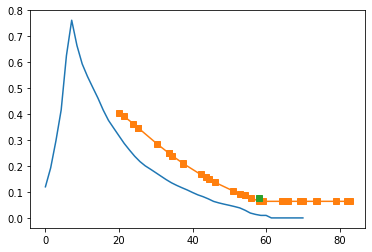

In [552]:
t = np.linspace(0, 70)
plt.plot(t, Catm(t+Dbirth[3]))
plt.plot(t_sim, s.y[3, :], marker='s')
plt.plot(t_sim, yobs[3,:], marker='s')
plt.show()

In [553]:
def ode_C_func_scaled(C, t, p):
    lambda_ = p[0] 
    t *= subject_age / scaled_age
    dC = (subject_age / scaled_age) * lambda_*(Catm(t + Dbirth) - C)
    return [dC[i] for i in range(n)]
#     return_string = '[' 
#     for i in range(n):
#         return_string += f'dC[{i}], '
#     return_string += ']'
#     return eval(return_string)

In [554]:
s2 = sp.integrate.solve_ivp(lambda t, y: ode_C_func_scaled(y, t, tuple([[lambda_true]])),
                                   t_span=[0, scaled_age],
                                   y0=Catm(Dbirth),
                                   method='BDF',
                                   t_eval=[scaled_age],
                           rtol=1e-3, atol=1e-6)

In [555]:
ode_C_model = DE(ode_C_func_scaled, times=[scaled_age], n_states=n, n_theta=1)

In [556]:
d14Cdata = yobs_1

In [542]:
%%time
with pm.Model() as POP1:
    lambda_ = pm.Uniform('lambda_', 0, 1, testval=0.1)
    sigma = pm.HalfNormal('sigma', 0.01)
    
    ode_C_solution = ode_C_model(y0=Catm(Dbirth), theta=[lambda_]).T.reshape(d14Cdata.shape)
    
    d14C = pm.Normal('d14C', mu=ode_C_solution, sd=sigma, observed=d14Cdata)

#     approx1 = pm.fit(n=10000)
    trace4 = pm.sample(200, tune=100, chains=1, compute_convergence_checks=False)

/home/fabrost/miniconda3/envs/spols191122/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))
Only 200 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [sigma, lambda_]
INFO:pymc3:NUTS: [sigma, lambda_]
Sampling chain 0, 0 divergences: 100%|██████████| 300/300 [01:05<00:00,  4.61it/s]
The acceptance probability does not match the target. It is 0.9504989848748844, but should be close to 0.8. Try to increase the number of tuning steps.


CPU times: user 1min 5s, sys: 159 ms, total: 1min 6s
Wall time: 1min 6s


In [420]:
pm.waic(trace4)

INFO (theano.gof.compilelock): Refreshing lock /home/fabrost/.theano/compiledir_Linux-4.4--default-x86_64-with-SuSE-42.3-x86_64-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/fabrost/.theano/compiledir_Linux-4.4--default-x86_64-with-SuSE-42.3-x86_64-x86_64-3.7.3-64/lock_dir/lock
/home/fabrost/miniconda3/envs/spols191122/lib/python3.7/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 200 by 41 log-likelihood matrix

        Estimate       SE
IC_waic  -198.74    11.09
p_waic      1.79        -

There has been a warning during the calculation. Please check the results.

In [557]:
%%time
with pm.Model() as POP1:
    lambda_ = pm.Uniform('lambda_', 0, 1, testval=0.1)
    sigma = pm.HalfNormal('sigma', 0.01)
    
    ode_C_solution = ode_C_model(y0=Catm(Dbirth), theta=[lambda_]).T.reshape(d14Cdata.shape)
    
    d14C = pm.Normal('d14C', mu=ode_C_solution, sd=sigma, observed=d14Cdata)

    approx1 = pm.fit(n=10000)
#     trace1 = pm.sample(100, tune=50, chains=4, compute_convergence_checks=False)

Average Loss = 3.9871e+10:   0%|          | 35/10000 [00:11<54:26,  3.05it/s]
Interrupted at 35 [0%]: Average Loss = 3.7628e+11
INFO:pymc3.variational.inference:Interrupted at 35 [0%]: Average Loss = 3.7628e+11


CPU times: user 54.7 s, sys: 41.3 s, total: 1min 36s
Wall time: 13.2 s


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f877be51ba8>],
      dtype=object)

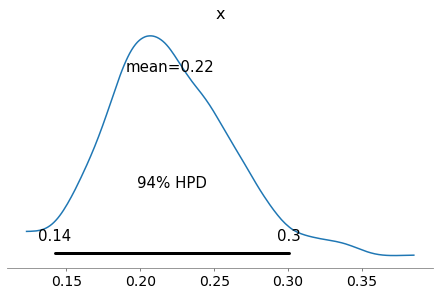

In [359]:
pm.plot_posterior(approx1.sample(1000)['lambda_'])

In [204]:
%%time
with pm.Model() as POP1:
    lambda_ = pm.Uniform('lambda_', 0, 1, testval=0.1)
    sigma = pm.HalfNormal('sigma', 0.01)
    
    ode_C_solution = ode_C_model(y0=Catm(Dbirth), theta=[lambda_]).T.reshape(d14Cdata.shape)
    
    d14C = pm.Normal('d14C', mu=ode_C_solution, sd=sigma, observed=d14Cdata)
    approx = pm.fit(n=10000)

#     trace = pm.sample(100, tune=50, chains=4, compute_convergence_checks=False)

Average Loss = -29.589: 100%|██████████| 10000/10000 [01:50<00:00, 90.85it/s]
Finished [100%]: Average Loss = -29.605
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = -29.605


CPU times: user 1min 51s, sys: 798 ms, total: 1min 52s
Wall time: 1min 51s


In [205]:
trace = approx.sample(1000)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f880cdcc978>],
      dtype=object)

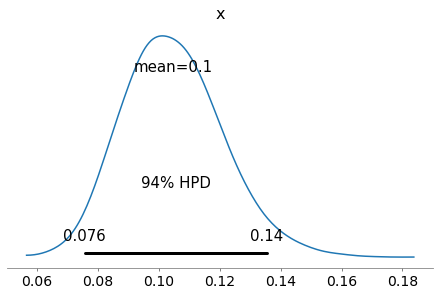

In [206]:
pm.plot_posterior(trace['lambda_'])

In [285]:
pm.waic(trace[::100])

Computed from 100 by 10 log-likelihood matrix

        Estimate       SE
IC_waic   -53.57     4.61
p_waic      8.32        -

There has been a warning during the calculation. Please check the results.

In [298]:
pm.loo(trace[::100])

/home/fabrost/miniconda3/envs/spols191122/lib/python3.7/site-packages/arviz/stats/stats.py:482: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 100 by 10 log-likelihood matrix

       Estimate       SE
IC_loo   -55.76     4.29
p_loo      7.23        -

There has been a warning during the calculation. Please check the results.

In [207]:
# %%time
# with pm.Model() as POP1_test:
#     lower = np.log10(0.0001)
#     upper = np.log10(0.1)
#     log10_lambda_ = pm.Uniform('log10_lambda_', lower, upper)
#     lambda_ = pm.Deterministic('lambda_', 10**log10_lambda_)
# #     BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
# #     lambda_ = BoundedNormal('lambda_', mu=0.01, sd=0.01, testval=0.01)
# #     lambda_ = pm.HalfFlat('lambda_', testval=0.1)
# #     lambda_ = pm.Uniform('lambda_', 0, 1, testval=0.1)
#     sigma = pm.HalfNormal('sigma', 0.01)
    
#     ode_C_solution = ode_C_model(y0=Catm(Dbirth), theta=[lambda_]).T.reshape(yobs_1.shape)
    
#     d14C = pm.Normal('d14C', mu=ode_C_solution, sd=sigma, observed=yobs_1)
# #     approx = pm.fit(n=100)
# #     map_ = pm.find_MAP()
    
# #     prior = pm.sample_prior_predictive()
# #     step = pm.Metropolis()
#     trace = pm.sample(200, tune=100, chains=4, compute_convergence_checks=False)
# #     posterior_predictive = pm.sample_posterior_predictive(trace)
    
# #     data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)

In [208]:
# import matplotlib.pyplot as plt
# import numpy as np
# import scipy.stats as st
# plt.style.use('seaborn-darkgrid')
# x = np.linspace(0, 0.1)
# for sigma in [0.01, 0.02]:
#     pdf = st.halfnorm.pdf(x, scale=sigma)
#     plt.plot(x, pdf, label=r'$\sigma$ = {}'.format(sigma))

# plt.axvline(d14C_obs_1.std())
# plt.xlabel('x', fontsize=12)
# plt.ylabel('f(x)', fontsize=12)
# plt.legend(loc=1)
# plt.show()

## 2n/4n

In [562]:
data = pd.read_csv('../data/C14data_liver_samples_20191023.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology != "Y"')
# data = data.query('ploidy == "2n4n"')
data = data[['sample', 'ploidy', 'Dbirth', 'age', 'd14C']]
# data['d14C'] *= 1000
data = data.sort_values('age')

# data = data.head(10)

data_unstack = (data
                .set_index('d14C', drop=False)
                .set_index(['sample', 'ploidy', 'Dbirth', 'age', 'age'], append=True)
                .unstack().T.loc['d14C'])
# for a in np.arange(0.0, data['age'].max(), 10):
#     if not a in data_unstack.index:
#         data_unstack.loc[a] = np.nan
data_unstack = data_unstack.sort_index()

age = data_unstack.index.values
d14C_obs = np.ma.masked_invalid(data_unstack.values).T

Dbirth = data_unstack.columns.to_frame()['Dbirth'].values
subject_age = data_unstack.columns.to_frame()['age'].values
ploidy_type = data_unstack.columns.to_frame()['ploidy'].values
d14C_obs_1 = data_unstack.columns.to_frame()['d14C'].values
n = data_unstack.shape[1]

mask_n2n4 = ploidy_type == '2n4n'
mask_n2 = ploidy_type == '2n'
mask_n4 = ploidy_type == '4n'

wn2 = np.empty_like(subject_age) 
wn4 = np.empty_like(subject_age) 

wn2[mask_n2n4] = ploidy(subject_age[mask_n2n4])
wn2[mask_n2] = ploidy(subject_age[mask_n2])
wn2[mask_n4] = 0

wn4[mask_n2n4] = 2*(1-ploidy(subject_age[mask_n2n4]))
wn4[mask_n2] = 2*ploidy2x2(subject_age[mask_n2])
wn4[mask_n4] = 1

wn2, wn4 = wn2/(wn2 + wn4), wn4/(wn2 + wn4)

scaled_age = 1

In [589]:
wn4

array([0.21022411, 0.41191694, 0.23907482, 0.40452625, 0.22123628,
       0.37754972, 0.58209125, 0.45936862, 0.45936862, 0.48877851,
       0.20068868, 0.21577488, 0.36924886, 0.38868827, 0.57712252,
       0.19538488, 0.25518647, 0.30230121, 0.25943966, 0.44810321,
       1.        , 0.44869286, 0.48330384, 0.37584799, 0.21613161,
       1.        , 0.32579799, 0.27588898, 0.25518647, 0.51428038,
       0.31066764, 0.18105967, 0.40566558, 0.51551496, 0.24667613,
       0.27497276, 0.35621396, 0.41020666, 0.28016809, 1.        ,
       1.        ])

In [563]:
def delta2_D(r2, r4, kappa24, kappa42, t):
    return -kappa24 - kappa42 + r2 + kappa42/ploidy(t) - (dtploidy(t)*(1 + ploidy(t))**2)/(2.*ploidy(t))

def delta4_D(r2, r4, kappa24, kappa42, t):
    return -(dtploidy(t)*(1 + ploidy(t))**2 + 4*(-kappa42 + r4 + (2*kappa24 + kappa42 - r4)*ploidy(t)))/(4.*(-1 + ploidy(t)))

In [580]:
def ode_C2C4_func_scaled(y, t, p):
    t *= (subject_age / scaled_age)
    C2 = y[:n]
    C4 = y[n:]
    
    r2 = p[0]
    r4 = p[1]
    kappa24 = p[2]
    kappa42 = p[3]
    
    delta2 = delta2_D(r2, r4, kappa24, kappa42, t)
    delta4 = delta4_D(r2, r4, kappa24, kappa42, t)
#     assert (delta2 > 0).all()
#     assert (delta4 > 0).all()
    
    dC2 = (subject_age / scaled_age) *(C2*kappa42 - C4*kappa42 - C2*r2 + r2*Catm(Dbirth + t) + ((-C2 + C4)*kappa42)/ploidy(t))
    dC4 = (subject_age / scaled_age) * ((-(C4*(delta4 + kappa42 - 2*r4)) + (-(C2*kappa24) + C4*(delta4 + 4*kappa24 + kappa42 - 2*r4))*ploidy(t) + Catm(Dbirth + t)*(-r4 + (-kappa24 + r4)*ploidy(t)))/(-1 + ploidy(t)))
    return [dC2[i] for i in range(n)] + [dC4[i] for i in range(n)]

In [581]:
r2_true = 0.1
r4_true = 0.02
kappa24_true = 0.01
kappa42_true = 0.001

In [582]:
s = sp.integrate.solve_ivp(lambda t, y: ode_C2C4_func_scaled(y, t,
                                                             [r2_true, r4_true,
                                                                     kappa24_true, kappa42_true]),
                                   t_span=[0, scaled_age],
                                   y0=np.concatenate([Catm(Dbirth), Catm(Dbirth)]),
                                   method='RK45',
                                   t_eval=[scaled_age])

In [583]:
C2 = s.y[:n, 0]
C4 = s.y[n:, 0]
y = wn2*C2 + wn4*C4

np.random.seed(42)
yobs = np.random.normal(loc=y, scale=sigma_true)

In [584]:
%%time
ode_C2C4_model = DE(ode_C2C4_func_scaled, times=[scaled_age], n_states=2*n, n_theta=4)

CPU times: user 53.7 s, sys: 1.68 s, total: 55.4 s
Wall time: 1min


In [587]:
%%time
Cdata = yobs

with pm.Model() as D:
    lower = 0
    upper = 1.0
    
    r2 = pm.Uniform('r2', lower, upper, testval=0.1)
    r4 = pm.Uniform('r4', testval=0.1)
    kappa24 = pm.Uniform('kappa24', testval=0.1)
    kappa42 = pm.Uniform('kappa42', testval=0.1)
    
    sigma = pm.Uniform('sigma', lower, upper)
    
    test_times = np.linspace(0, subject_age.max(), 10)
    for t in test_times:
        pm.Potential(f'delta2_{t}',
                     (delta2_D(r2, r4, kappa24, kappa42, t)<0) * 10*delta2_D(r2, r4, kappa24, kappa42, t)**2)
        pm.Potential(f'delta4_{t}',
                     (delta4_D(r2, r4, kappa24, kappa42, t)<0) * 10*delta4_D(r2, r4, kappa24, kappa42, t)**2)
    
    ode_C2C4_solution = ode_C2C4_model(y0=np.concatenate([Catm(Dbirth), Catm(Dbirth)]), 
                                       theta=[r2, r4, kappa24, kappa42])
    
    C2 = ode_C2C4_solution[0, :n]
    C4 = ode_C2C4_solution[0, n:]
    mu = wn2*C2 + wn4*C4
    
    d14C = pm.Normal('d14C', mu=mu, sd=sigma, observed=Cdata)
#     map_ = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(500, chains=1, compute_convergence_checks=False, step=step)
#     approx2 = pm.fit(n=10000)

INFO (theano.gof.compilelock): Refreshing lock /home/fabrost/.theano/compiledir_Linux-4.4--default-x86_64-with-SuSE-42.3-x86_64-x86_64-3.7.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/fabrost/.theano/compiledir_Linux-4.4--default-x86_64-with-SuSE-42.3-x86_64-x86_64-3.7.3-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [sigma]
INFO:pymc3:>Metropolis: [sigma]
>Metropolis: [kappa42]
INFO:pymc3:>Metropolis: [kappa42]
>Metropolis: [kappa24]
INFO:pymc3:>Metropolis: [kappa24]
>Metropolis: [r4]
INFO:pymc3:>Metropolis: [r4]
>Metropolis: [r2]
INFO:pymc3:>Metropolis: [r2]
Sampling chain 0, 0 divergences:   0%|          | 1/1000 [03:15<54:18:38, 195.71s/it]

CPU times: user 12min 3s, sys: 16min 23s, total: 28min 27s
Wall time: 4min 31s
